# Оптимизация стратегии удержания клиентов

**Заказчик** — Сеть фитнес-центров «Культурист-датасаентист».

**Цель исследования** - Отток клиентов является распространенной и серьезной проблемой для фитнес-центров. Сеть «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами, чтобы бороться с оттоком. Необходимо провести анализ и разработать план по удержанию клиентов.

**Исходные данные** — статистика по клиентам, данные на месяц до оттока и факт оттока на определённый месяц.

**Вопросы, которые интересуют заказчика**

- подготовить модель для прогнозирования вероятности оттока;
- сформировать типичные группы клиентов и выделить их ключевые характеристики;
- проанализировать основные признаки, влияющие на отток;
- сформулировать выводы и рекомендации по повышению качества работы с клиентами.


## Исходные данные

Начнем работу с загрузки и знакомства с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

# активируем настройку по отображению всех столбцов
pd.set_option('display.max_columns', None)

data = pd.read_csv('gym_churn.csv')
data.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Описание данных**
- Churn — факт оттока в текущем месяце

**Данные клиента за предыдущий до проверки факта оттока месяц**
- gender — пол
- Near_Location — проживание или работа в районе, где находится фитнес-центр
- Partner — сотрудник компании-партнёра клуба
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга»
- Phone — наличие контактного телефона
- Age — возраст
- Lifetime — время с момента первого обращения в фитнес-центр (в месяцах)

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента**
- Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах)
- Group_visits — факт посещения групповых занятий
- Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента
- Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц
- Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

## Исследовательский анализ данных

### Общий осмотр данных

Приступим к проверке датасета

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Названия столбцов в порядке, форматы подходящие, пропусков также не наблюдается. Все категориальные переменные имеют подходящий формат.

Не лишним будет проверить признаки, есть ли какие-то аномальные выбросы в значениях, насколько они далеки от нормального распределения.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


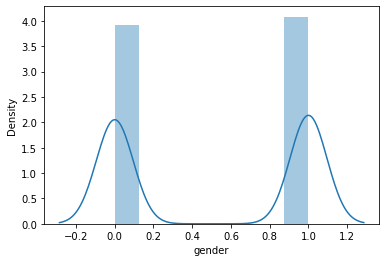

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


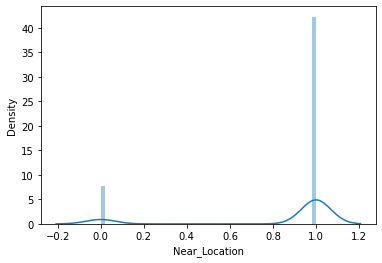

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


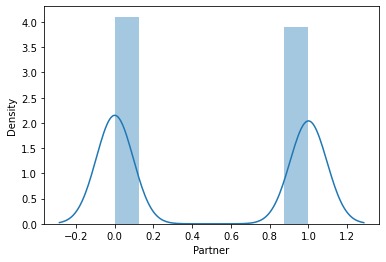

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


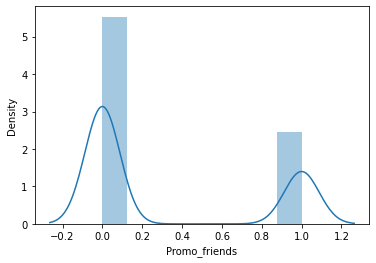

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


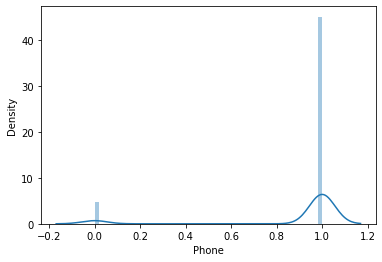

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


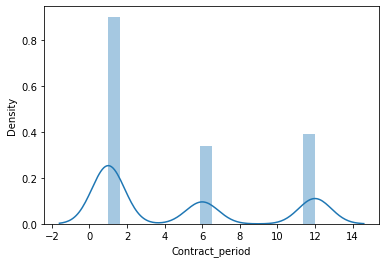

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


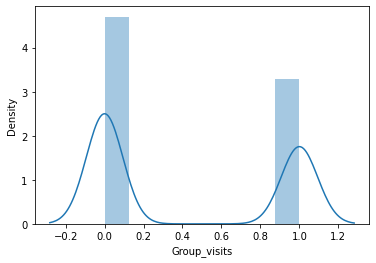

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


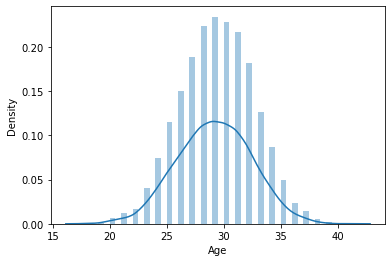

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


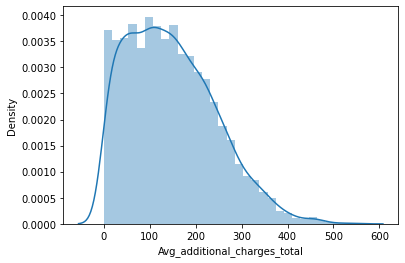

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


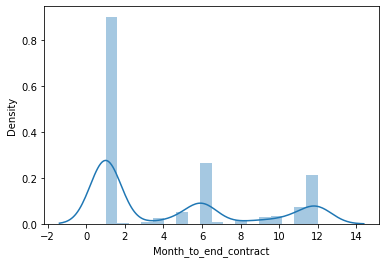

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


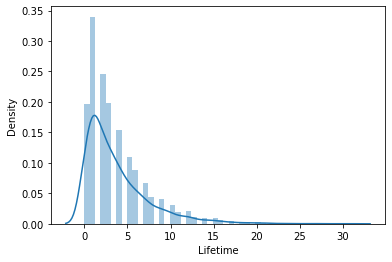

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


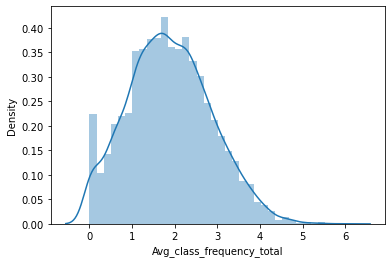

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


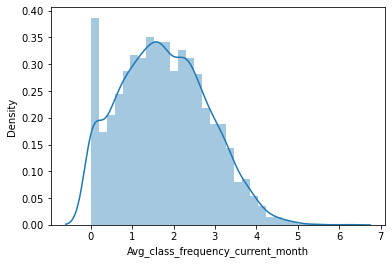

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


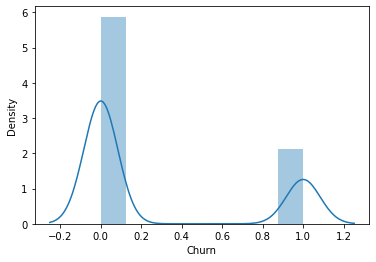

In [3]:
import seaborn as sns

for feature in data.columns:
    sns.distplot(data[feature])
    plt.show() 

По характеру гистограмм преимущеcтвенно все в порядке. Но стоит подробнее рассмотреть признаки: lifetime и оба Avg_class_frequency

**lifetime**

count    4000.000000
mean        3.724750
std         3.749267
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        31.000000
Name: Lifetime, dtype: float64


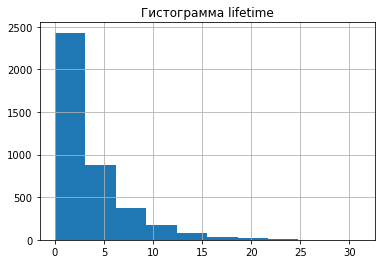

In [4]:
print(data['Lifetime'].describe())
data['Lifetime'].hist()
plt.title('Гистограмма lifetime')
plt.show()

Можем видеть хвост из нескольких значений, сильно больше основной массы.

count    4000.000000
mean        3.724750
std         3.749267
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        31.000000
Name: Lifetime, dtype: float64


3952

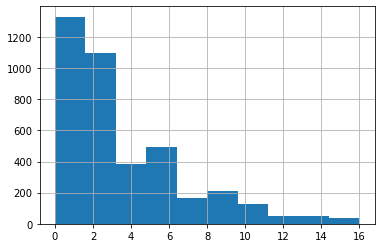

In [5]:
data.query('Lifetime < 17')['Lifetime'].hist()
print(data['Lifetime'].describe())
len(data.query('Lifetime < 17')['Lifetime'])

Для значений больше 16 мес. всего 48 строк, думаю стоит их отбросить для улучшения точности модели. Также среднее значение немного приблизилось к медиане.

In [6]:
data = data[data['Lifetime'] < 17]

**Avg_class_frequency**

count    3952.000000
mean        1.880641
std         0.972626
min         0.000000
25%         1.180875
50%         1.833908
75%         2.538075
max         6.023668
Name: Avg_class_frequency_total, dtype: float64


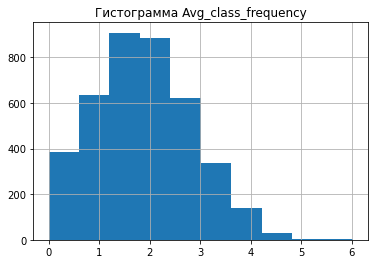

In [7]:
print(data['Avg_class_frequency_total'].describe())
data['Avg_class_frequency_total'].hist()
plt.title('Гистограмма Avg_class_frequency')
plt.show()


count    3952.000000
mean        1.766964
std         1.054523
min         0.000000
25%         0.960069
50%         1.719093
75%         2.512273
max         6.146783
Name: Avg_class_frequency_current_month, dtype: float64


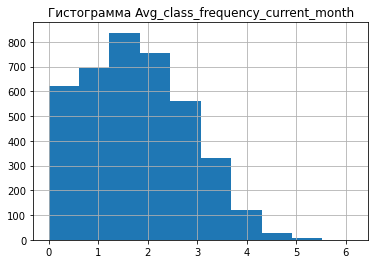

In [8]:
print(data['Avg_class_frequency_current_month'].describe())
data['Avg_class_frequency_current_month'].hist()
plt.title('Гистограмма Avg_class_frequency_current_month')
plt.show()

На графике при первой выгрузке был сильный всплеск около нуля, сейчас гистограмма выглядит нормально, стандартное отклонение = 1, возможно повлияло сокращение данных.

### Баланс целевого показателя

Важным показателем для моделей классификации является сбалансированность целевого показателя. Проверим.

In [9]:
data['Churn'].value_counts()

0    2891
1    1061
Name: Churn, dtype: int64

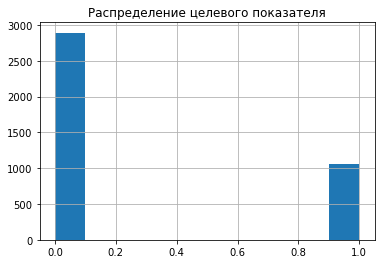

In [10]:
data['Churn'].hist()
plt.title('Распределение целевого показателя')
plt.show()

Можно заметить, что 27% клиентов прекратили членство в клубе, и 73% остались. Будем считать такое соотношение приемлемым для дальнейшей работы.

### Сравнение ушедших и действующих клиентов

Для общего понимания значений признаков по целевым группам, проанализируем.

In [11]:
data_churn_gr = data.groupby('Churn').mean()
data_churn_gr

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.509512,0.872708,0.536838,0.354203,0.903840,5.746800,0.461432,29.977171,158.485996,5.284331,4.455206,2.029513,2.032092
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Полученные результаты наталкивают на интересные выводы:
- такие показатели, как пол, Телефон и Возраст почти одинаковы, следовательно не характеризуют группы;
- можно заметить, что перестают посещать фитнес клиенты "с улицы" чаще, вероятно находят более выгодные предложения, и перед коллегами с работы не стыдно;
- акция "приведи друга" явно работает, вместе веселее заниматься спортом;
- клиенты, кто изначально приобретал абонемент на срок от полугода, делали это значительно более осознано, у них есть цель;
- посещение групповых занятий притягивает, возможно появляются новые контакты у посетителей, это явно плюс к удержанию аудитории;
- замечено, те кто в фитнесе на долго, больше тратят на доп. услуги;
- очевидно, те кто держатся в клубе давно, вероятнее остаются и в дальнейшем;
- заядлые спортсмены посещают фитнес не реже 2 раз в неделю.

Что же, эти сведения нам очень пригодятся в дальнейшем.

Не лишним будет посмотреть на распределение признаков по этим группам.

gender


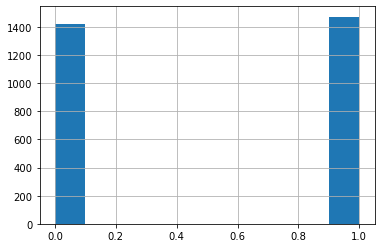

Near_Location


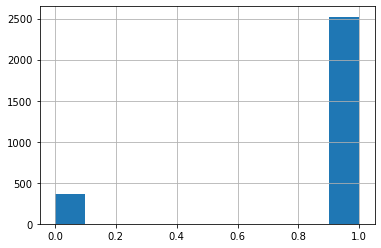

Partner


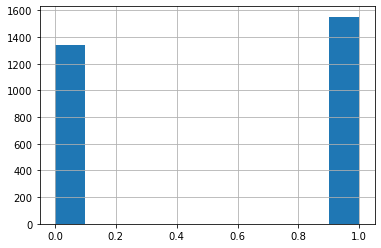

Promo_friends


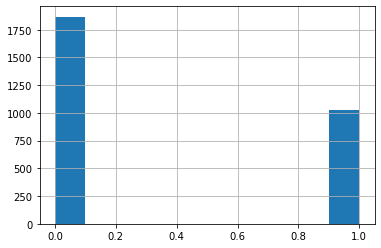

Phone


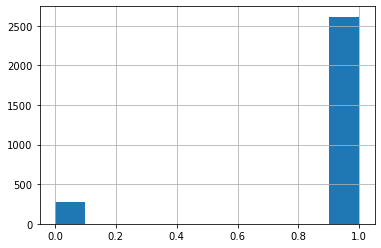

Contract_period


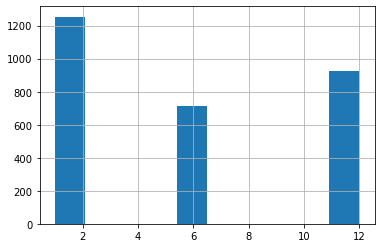

Group_visits


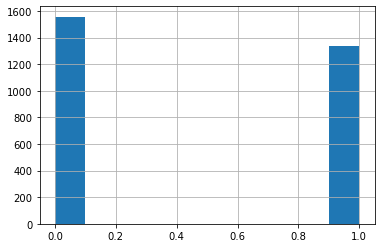

Age


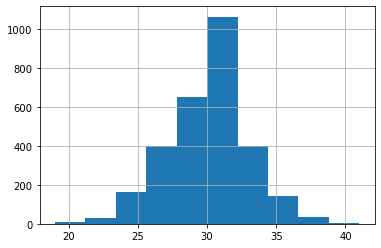

Avg_additional_charges_total


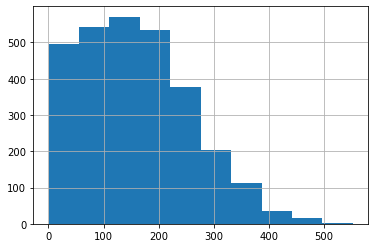

Month_to_end_contract


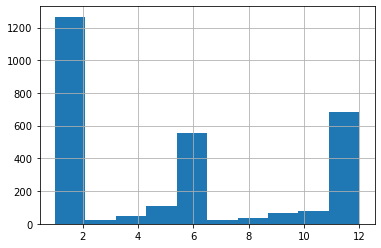

Lifetime


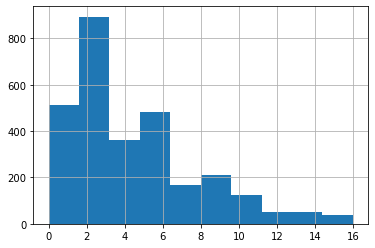

Avg_class_frequency_total


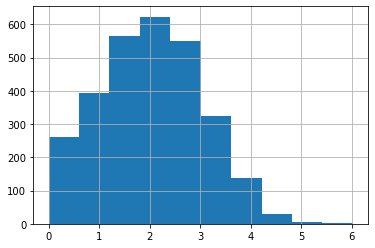

Avg_class_frequency_current_month


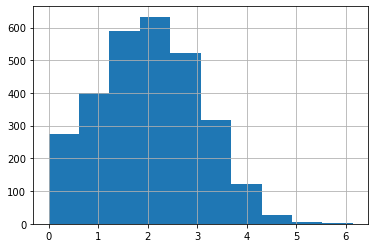

Churn


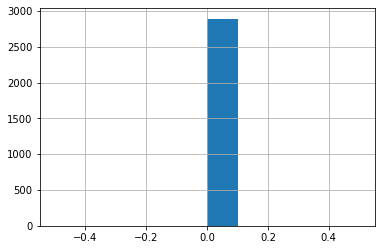

In [12]:
for feature in data.columns:
    print(feature)
    data.query('Churn == 0')[feature].hist()
    plt.show() 

Теперь для ушедших клиентов.

gender


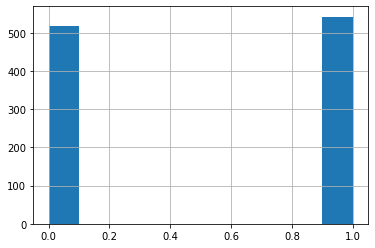

Near_Location


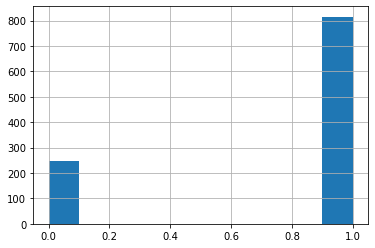

Partner


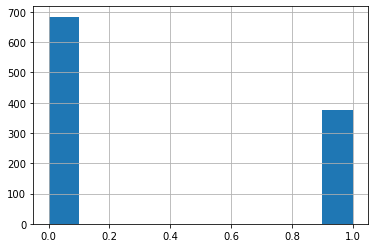

Promo_friends


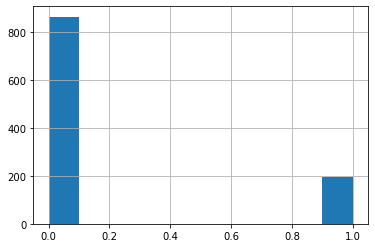

Phone


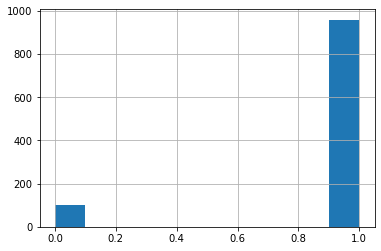

Contract_period


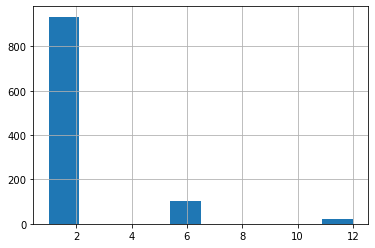

Group_visits


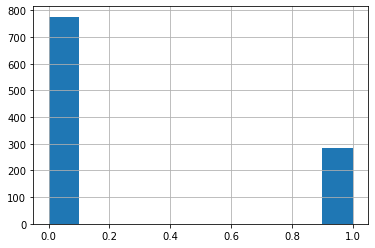

Age


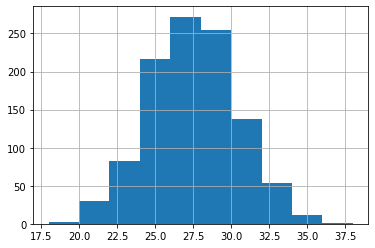

Avg_additional_charges_total


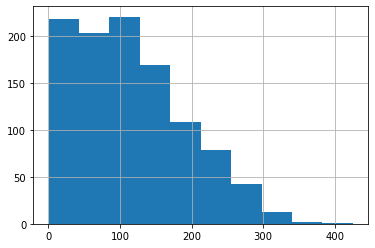

Month_to_end_contract


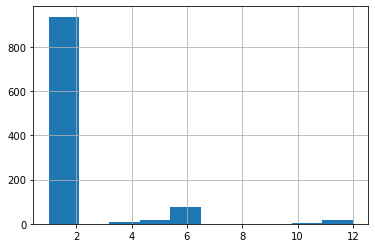

Lifetime


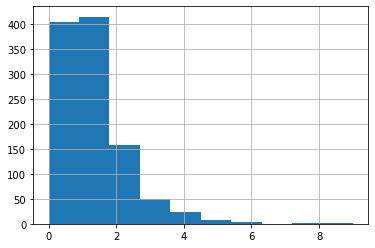

Avg_class_frequency_total


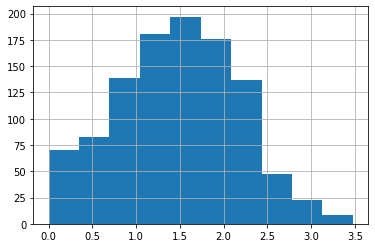

Avg_class_frequency_current_month


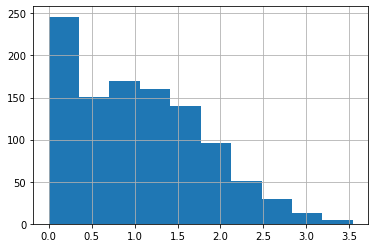

Churn


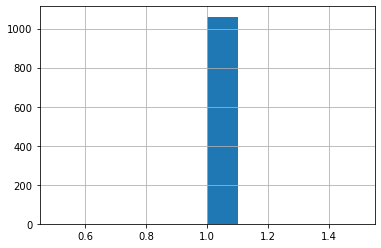

In [13]:
for feature in data.columns:
    print(feature)
    data.query('Churn == 1')[feature].hist()
    plt.show() 

По сравнению распределений между группами, можно видеть подтверждение вышеуказанных выводов. По сравнению с исходными данными, каких-то резких отличий по части характера распределения данных, не замечено. Важно отметить, несмотря на описание поля "Contract_period", в выборке мы имеем контракты на 1 месяц, пол года и год.

### Корреляция

Рассмотрим корреляцию между признаками, будет важно понять, есть ли мультиколлинеарность, и какие признаки сильнее влияют на целевой показатель.

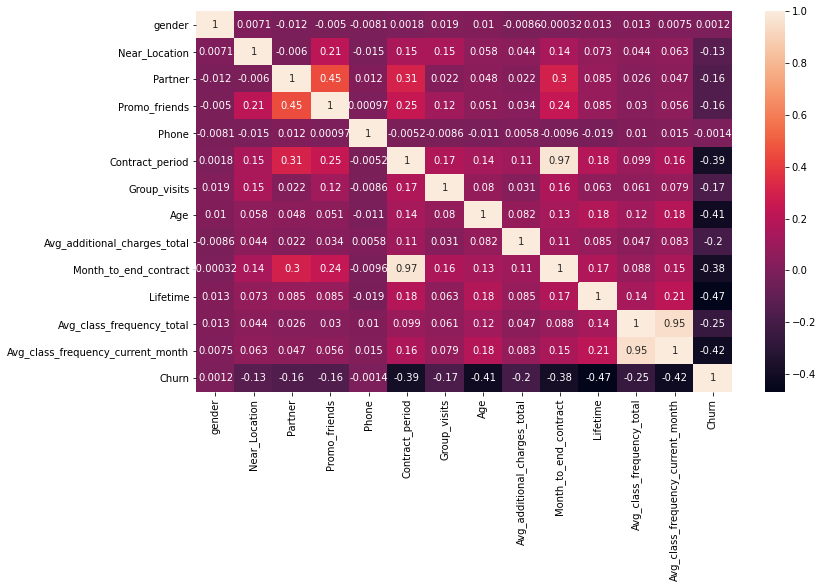

In [14]:
cm = data.corr()

plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot = True)
plt.show()

По матрице можем сразу заметить мультиколлинеарность между столбцами Contract_period и Month_to_end_contract, что понятно. А столбцы Avg_class_frequency_total и Avg_class_frequency_current_month описывают одно и то же, только за разный период. 
Помимо этого, можно заметить что не наблюдается сильного влияния признаков на целевой показатель, ни один признак не превысил 0,5.

Для преодоления обозначенной проблемы уберем из выборки 2 признака - Avg_class_frequency_current_month и Month_to_end_contract как менее важные.

In [15]:
data = data.drop(['Avg_class_frequency_current_month', 'Month_to_end_contract'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3952 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        3952 non-null   int64  
 1   Near_Location                 3952 non-null   int64  
 2   Partner                       3952 non-null   int64  
 3   Promo_friends                 3952 non-null   int64  
 4   Phone                         3952 non-null   int64  
 5   Contract_period               3952 non-null   int64  
 6   Group_visits                  3952 non-null   int64  
 7   Age                           3952 non-null   int64  
 8   Avg_additional_charges_total  3952 non-null   float64
 9   Lifetime                      3952 non-null   int64  
 10  Avg_class_frequency_total     3952 non-null   float64
 11  Churn                         3952 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 401.4 KB


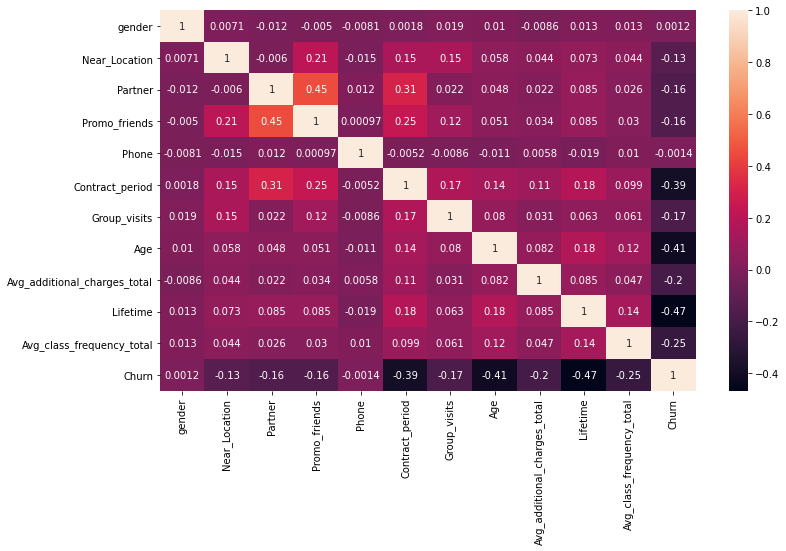

In [16]:
cm2 = data.corr()

plt.figure(figsize=(12, 7))
sns.heatmap(cm2, annot = True)
plt.show()

Так лучше.

### Попарное распределение

Посмотрим на попарное распределение основных признаков и целевой переменной, определим важность признака.

**Near_Location**

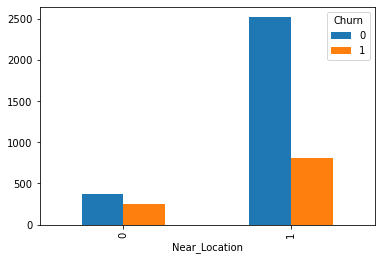

In [17]:
pd.crosstab(data['Near_Location'], data['Churn']).plot(kind = 'bar')
plt.show()

Отдаленность от клуба имеет влияние на решение о продлении абонемента, так соотношение в пользу клуба значительно больше у тех, кто живет поблизости.

**Contract_period**

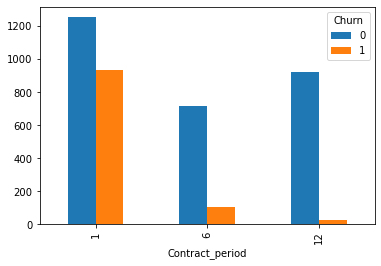

In [18]:
pd.crosstab(data['Contract_period'], data['Churn']).plot(kind = 'bar')
plt.show()

Определенно критерий имеет высокое влияние, очень сильно разнятся отказники в зависимости от срока контракта, не стоит продавать абонементы на 1 месяц.

**Partner**

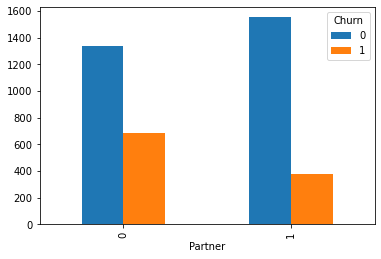

In [19]:
pd.crosstab(data['Partner'], data['Churn']).plot(kind = 'bar')
plt.show()

Если среди сторонних клиентов уходит половина, то среди партнерских фирм лишь четверть, заметная разница.

**Promo_friends**

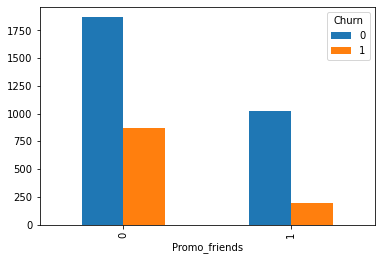

In [20]:
pd.crosstab(data['Promo_friends'], data['Churn']).plot(kind = 'bar')
plt.show()

Схожая ситуация, как с Партнерами, очевидно, скидки имеют серьезный эффект.

**Phone**

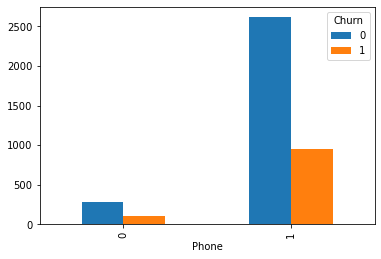

In [21]:
pd.crosstab(data['Phone'], data['Churn']).plot(kind = 'bar')
plt.show()

Можно наблюдать почти одинаковое соотношение оттока по тем, кто дал телефон, и кто нет. Следовательно, влияния нет. Да еще и число клиентов, кто не оставил номера, сильно меньше. Думаю можно пренебречь этим фактором.

**Gender**

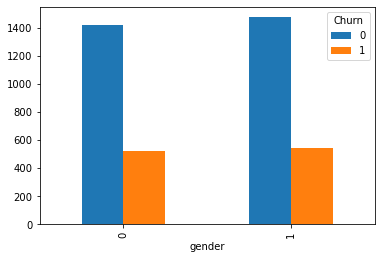

In [22]:
pd.crosstab(data['gender'], data['Churn']).plot(kind = 'bar')
plt.show()

Не наблюдается значимой зависимости.

**Age**

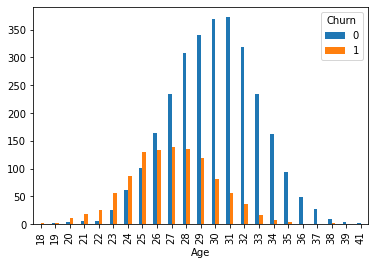

In [23]:
pd.crosstab(data['Age'], data['Churn']).plot(kind = 'bar')
plt.show()

Можно отметить, что более старшие спортсмены, от 28 лет, сильно реже покидают клуб.

**Group_visits**

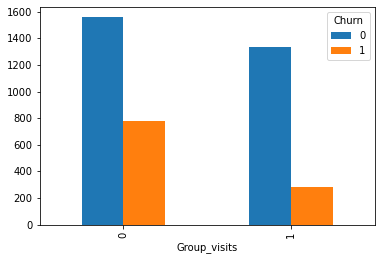

In [24]:
pd.crosstab(data['Group_visits'], data['Churn']).plot(kind = 'bar')
plt.show()

Половина клиентов, кто не посещает групповые занятия, уходят. А среди посещающих лишь 25%.

Прочие признаки либо носят количественный характер, и по ним достаточно увидеть распределение, что уже сделано выше, либо они исключены. По итогам анализа парного распределения, можно опустить признак Phone.

In [25]:
data = data.drop('Phone', axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3952 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        3952 non-null   int64  
 1   Near_Location                 3952 non-null   int64  
 2   Partner                       3952 non-null   int64  
 3   Promo_friends                 3952 non-null   int64  
 4   Contract_period               3952 non-null   int64  
 5   Group_visits                  3952 non-null   int64  
 6   Age                           3952 non-null   int64  
 7   Avg_additional_charges_total  3952 non-null   float64
 8   Lifetime                      3952 non-null   int64  
 9   Avg_class_frequency_total     3952 non-null   float64
 10  Churn                         3952 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 370.5 KB


Работа по подготовке данных завершена, лишние признаки исключены, мультиколлинеарность убрана.

## Модель прогнозирования оттока клиентов

Данные изучили и проверили, приступим к построению модели. Так как необходимо построить модель прогнозирования оттока клиентов, то есть целевой показатель может принимать 0 или 1. В таком случае будем использовать модели бинарной классификации. Для целей проекта будем использовать наиболее распространенную модель логистической регрессии. Чтобы оценить точность модели также построим прогноз алгоритмом Случайного леса, он сложнее и, зачастую, точнее. Загрузим необходимые библиотеки.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

Первым шагом выделим признаки и целевой показатель.

In [27]:
X = data.drop('Churn', axis=1)
y = data['Churn']

Теперь выделим обучающую и валидационную выборки.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

Стандартизируем выборку.

In [29]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Зададим алгоритм для нашей модели логистической регрессии и обучим.

In [30]:
regr_model = LogisticRegression(solver='liblinear', random_state = 0)
regr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0, solver='liblinear')

Воспользуемся уже обученной моделью, чтобы сделать прогнозы.

In [31]:
regr_predictions = regr_model.predict(X_test_st)
regr_probabilities = regr_model.predict_proba(X_test_st)[:, 1]

Выведем метрики для полученного прогноза.

In [32]:
Accuracy = accuracy_score(y_test, regr_predictions).round(2)
Precision = precision_score(y_test, regr_predictions).round(2)
Recall = recall_score(y_test, regr_predictions).round(2)
ROC_AUC = roc_auc_score(y_test, regr_probabilities).round(2)
print('Accuracy:', Accuracy)
print('Precision:', Precision)
print('Recall:', Recall)
print('ROC_AUC:', ROC_AUC)

Accuracy: 0.89
Precision: 0.79
Recall: 0.77
ROC_AUC: 0.94


Проделаем те же шаги для модели случайного леса.

In [33]:
# Зададим алгоритм для нашей модели
forest_model = RandomForestClassifier(random_state = 0)
forest_model.fit(X_train_st, y_train)

# Сделаем прогнозы
forest_predictions = forest_model.predict(X_test_st)
forest_probabilities = forest_model.predict_proba(X_test_st)[:, 1]

# Выведем метрики для полученного прогноза
Accuracy = accuracy_score(y_test, forest_predictions).round(2)
Precision = precision_score(y_test, forest_predictions).round(2)
Recall = recall_score(y_test, forest_predictions).round(2)
ROC_AUC = roc_auc_score(y_test, forest_probabilities).round(2)
print('Accuracy:', Accuracy)
print('Precision:', Precision)
print('Recall:', Recall)
print('ROC_AUC:', ROC_AUC)

Accuracy: 0.89
Precision: 0.79
Recall: 0.75
ROC_AUC: 0.93


При сравнении метрик становится ясно, что модель логистической регрессии получилась немного лучше. Остановимся на ней.

## Кластеризация клиентов

Проведем кластеризацию клиентов, это поможет выделить группы клиентов и предложить каждому сегменту подходящий вариант продукта и точное взаимодействие. Для формирования сегментов применим алгоритм Kmeans.

In [34]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

### Дендрограмма

Для выбранного нами алгоритма необходимо указать требуемое число групп. Для определения числа групп воспользуемся методом Агломеративной иерархической кластеризации.

Стандартизируем данные.

In [35]:
sc = StandardScaler()
x_sc = sc.fit_transform(X)

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

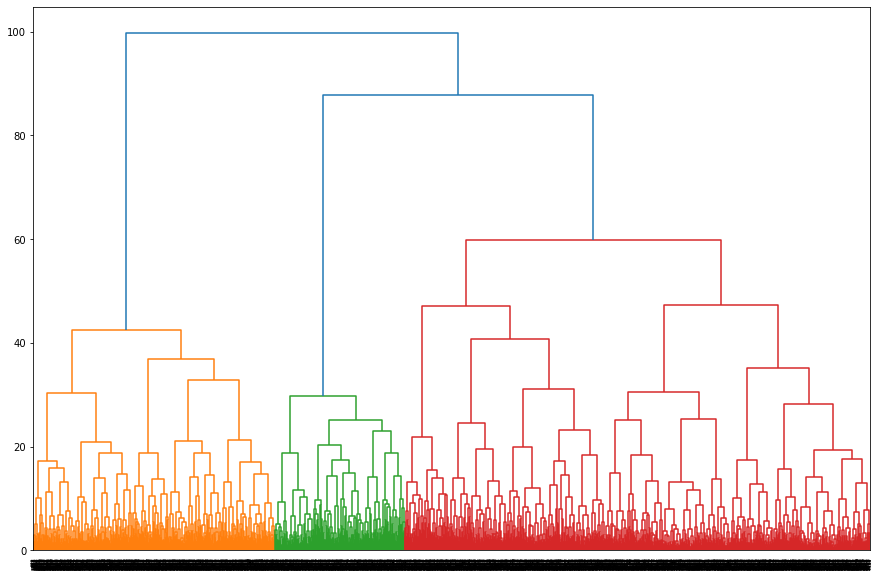

In [36]:
linked = linkage(x_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Представляется оптимальным число кластеров - 5. Дополнительно два в зеленом сегменте, и два в голубом.

### Модель кластеризации

Построим модель кластеризации алгоритмом K-Means. Число кластеров нам уже ясно, сформируем их.

In [37]:
km = KMeans(n_clusters = 5, random_state = 0)

labels = km.fit_predict(x_sc)

Проверим качество кластеризации метрикой силуэта.

In [38]:
Silhouette = silhouette_score(x_sc, labels).round(2)
print('Silhouette_score:', Silhouette)

Silhouette_score: 0.12


Результат не высокий, тем не менее, признаков у нас много, а клиенты могли быть весьма похожи. Остановимся на этом результате.

### Описание групп

Сохраняем метки кластера в поле нашего датасета и выведем средние показатели по созданным кластерам.

In [39]:
data['cluster_km'] = labels
ft_df = data.groupby('cluster_km').mean()
ft_df.sort_values('Churn', ascending = False)

,gender,Near_Location,Partner,Promo_friends,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
cluster_km,,,,,,,,,,,
3,1.000000,1.000000,0.213936,0.075795,2.344743,0.342298,28.315403,129.748901,2.195599,1.711413,0.431540
4,0.500826,0.000000,0.490909,0.074380,2.963636,0.228099,28.694215,136.839236,2.867769,1.769192,0.404959
2,0.000000,1.000000,0.225124,0.063433,2.539801,0.333333,28.573383,128.212977,2.465174,1.597437,0.400498
1,0.494737,0.995215,0.929187,1.000000,7.051675,0.516746,29.534928,152.063756,4.088038,1.943409,0.130144
0,0.554412,0.994118,0.448529,0.023529,7.832353,0.577941,30.795588,190.255548,6.097059,2.421755,0.007353


Группы по заданным номерам расположим по порядку убывания целевого показателя. Средние показатели по группам наводят на следующие выводы:
- пятая группа - половина мужчин, проживают территориально далеко, половина клиентов работают в фирмах-партнерах, иных скидок не имеют, приобретали абонемент преимущественно на 1 месяц, 80% не посещают групповых занятий, в среднем посещают клуб уже 3 месяца, посещают зал в лучшем случае 2 раза в неделю, 40% подобных клиентов перестают ходить;
- четвертая группа - ее составляют только мужчины, проживающие в непосредственной близости от клуба, только 18% работают у партнеров и друзей особо не приводят, приобретали абонемент преимущественно на 1 месяц. Вдвое охотнее посещают групповые занятия, в остальном все так же, как в пятой группе.;
  - тут можно подметить, что близость к фитнесу компенсирует отсутствие скидок, все же людям важно заниматься рядом с домом; 
- первая группа идентична четвертой, отличается по полу, в ней только женщины;
- вторая группа - состоит поровну из М и Ж, живут близко и все работают у партнеров, все имеют доп. скидки, по таким ценам готовы заключать контракты на 6 мес. и более, половина ходит на групповые занятия и тратят на 13% больше на доп расходы, такие целеустремленные культуристы ходят 2 раза в неделю и не устают! наконец то мы фиксируем улучшение лояльности, только 13% таких клиентов готовы уйти.
  - становится очевидным, при наличии скидок близко к дому, люди готовы покупать длинные абонементы, им нравится, значительно чаще ходят на групповые занятия, все это удерживает аудиторию. Как следствие, довольные клиенты готовы на 13% больше тратить на доп. услуги!
- третья группа - определенно состоит из целеустремленных людей, они знают, что им надо, в отличие от второй группы только половина работает у партнеров, а по акции не пришел никто. Абонементы чаще годовые, активно ходят на групповые занятия, тратят еще больше денег в среднем и даже не думают уходить.

## Выводы и рекомендации по работе с клиентами

В рамках проекта проведена большая последовательная работа:
- выгружены и проверены данные; 
- проведен исследовательский анализ данных (EDA), обнаружен небольшой хвост значений в Lifetime, убран выброс, оценены признаки по гистограммам;
- исходную выборку сгруппировали по целевому показателю, выявили ключевые различия, характеризующие полученные части:
  - чаще перестают посещать фитнес клиенты "с улицы";
  - акция "приведи друга" имеет эффект, среди оставшихся на 15% больше;
  - клиенты, кто оформил абонемент на срок от полугода охотнее остаются;
  - для группы лояльных людей характерно посещение не реже 2 раз в неделю;
- перед построением модели построена корреляционная матрица, проверены признаки методом попарного распределения с ключевым показателем;
- по итогу анализа, убраны признаки, имеющие слабое влияние, как то Phone, признаки, создающие мультиколлинеарность - Avg_class_frequency_current_month' и 'Month_to_end_contract';
- построены 2 модели по алгоритмам логистической регрессии и случайного леса, выбрана оптимальная по метрикам Accuracy, Precision, Recall и ROC_AUC;
- так, итоговая модель имеет ROC_AUC: 0.94;
- проведена кластеризация выборки двумя алгоритмами, сперва определили кол-во групп с помощью Агломеративной иерархической кластеризации, задали 5 групп;
- вторым шагом провели сегментацию методом KMeans, с помощью метрики Silhouette оценили результат;
- проведено подробное описание полученных групп с выделением особых черт.

Весь этот комплекс работ позволяет сформулировать основные рекомендации для построения оптимальной стратегии:
- с применением построенных моделей важно точно определить группу клиентов, готовых постоянно посещать фитнес без дополнительных маркетинговых усилий, такая группа - третья в нашей модели. Можно воспользоваться их целеустремленностью и предлагать повышенные цены за особые услуги и доп. занятия, возможно предоставление особого статуса после "выслуги лет". В целом эта аудитория готова заниматься и тратить деньги на спорт;
- как группа заинтересованных, есть и, наоборот, группа клиентов, кто не сильно смотивирован, они приходят преимущественно по партнерской программе, редко ходят и не посещают групповых занятий, эти факторы могут стать важным сигналом. Отмечено, что близость к залу и наличие скидок сильно влияют на неокрепшую аудиторию. Поэтому тщательно работайте с этим сегментом, для тех, кто живет поодаль, проработайте скидочную систему, или мотивацию ходить в дальнейшем, если же клиент по-близости, то надо вовлекать в групповые занятия;
- Те кто посещает групповые занятия, в целом склонны остаться. В процессе взаимодействия формируются связи, люди охотнее ходят вместе в последующем;
- фактор возраста показал, что более взрослая часть посещает фитнес увереннее, поэтому для более молодых целесообразно предложить выгодный абонемент. Делайте упор на продажу длительных контрактов, с ними посетители вероятнее продолжают ходить.